# Grid Results Analysis

This notebook analyzes the parameter optimization results from grid search stored in JSON files. We'll visualize the performance across different parameter combinations and identify optimal settings.

In [77]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from datetime import datetime

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

## Loading Grid Results Data

First, let's load the grid results data from the JSON files in the results directory.

In [78]:
# Path to the results directory
results_dir = os.path.join('..', 'results')

# Get all JSON files in the results directory
json_files = glob(os.path.join(results_dir, 'grid_results_*.json'))
print(f"Found {len(json_files)} grid results files.")

# Function to load JSON data
def load_grid_results(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data, os.path.basename(file_path)

# Load the most recent grid results file
if json_files:
    # Sort by modification time (newest first)
    json_files.sort(key=os.path.getmtime, reverse=True)
    latest_file = json_files[0]
    grid_results, filename = load_grid_results(latest_file)
    print(f"Loaded {len(grid_results)} parameter combinations from {filename}")
else:
    print("No grid results files found.")
    grid_results = []

Found 1 grid results files.
Loaded 364 parameter combinations from grid_results_2025-04-13_19-04-18.json


## Converting to DataFrame

Let's convert the grid results to a pandas DataFrame for easier analysis.

In [79]:
# Convert grid results to DataFrame
def grid_results_to_df(grid_results):
    rows = []
    for result in grid_results:
        row = {
            'THRESHOLD': result['THRESHOLD'],
            'WINDOW': result['WINDOW'],
        }
        # Add profit summary data
        if 'profit_summary' in result:
            for day, profit in result['profit_summary'].items():
                row[day] = profit
        rows.append(row)
    return pd.DataFrame(rows)

# Convert to DataFrame
df = grid_results_to_df(grid_results)

# Display basic information
print("DataFrame shape:", df.shape)
df.head()

DataFrame shape: (364, 6)


,THRESHOLD,WINDOW,day_-1,day_0,day_1,total
0,0.1,5,4738,-8285,-3530,-7077
1,0.1,25,10254,92,1794,12140
2,0.1,50,24279,4072,5523,33874
3,0.1,75,29080,6144,8033,43257
4,0.1,100,33541,9519,8737,51797


## Basic Statistics

Let's look at some basic statistics of the results.

In [80]:
# Basic statistics
df.describe()

,THRESHOLD,WINDOW,day_-1,day_0,day_1,total
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,1.382692,212.500000,17264.557692,11853.074176,10644.585165,39762.211538
std,1.151494,158.554724,19520.434289,14856.575277,9286.471583,38863.618798
min,0.100000,5.000000,0.000000,-8285.000000,-3530.000000,-7077.000000
25%,0.600000,75.000000,0.000000,0.000000,0.000000,0.000000
50%,1.050000,175.000000,7482.500000,9690.500000,13434.500000,35688.000000
75%,1.800000,350.000000,36181.000000,15603.000000,17872.250000,69086.000000
max,5.000000,500.000000,63195.000000,61825.000000,33861.000000,133690.000000


In [81]:
# Check unique values for parameters
print("Unique THRESHOLD values:", sorted(df['THRESHOLD'].unique()))
print("Unique WINDOW values:", sorted(df['WINDOW'].unique()))

Unique THRESHOLD values: [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.0, 2.2, 2.4, 3.0, 4.0, 5.0]
Unique WINDOW values: [5, 25, 50, 75, 100, 120, 150, 200, 250, 300, 350, 400, 450, 500]


## Performance Analysis

Let's analyze the performance across different parameter combinations.

In [82]:
# Find the best performing parameter combinations
best_total = df.sort_values('total', ascending=False).head(10)
print("Top 10 parameter combinations by total profit:")
best_total

Top 10 parameter combinations by total profit:


,THRESHOLD,WINDOW,day_-1,day_0,day_1,total
102,0.65,100,53692,61414,18584,133690
22,0.20,250,63195,47179,21377,131751
75,0.55,120,48601,61825,19540,129966
35,0.30,200,51040,57147,21459,129646
116,0.70,100,53362,55504,19847,128714
88,0.60,100,53201,58096,16568,127865
89,0.60,120,50191,54929,21568,126688
36,0.30,250,40722,54530,30435,125686
61,0.50,120,46570,58939,18882,124391
23,0.20,300,43997,52960,25557,122514


In [83]:
# Find the best performing parameter combinations for each day
day_columns = [col for col in df.columns if col.startswith('day_')]

for day in day_columns:
    best_day = df.sort_values(day, ascending=False).head(5)
    print(f"\nTop 5 parameter combinations for {day}:")
    print(best_day[['THRESHOLD', 'WINDOW', day]])


Top 5 parameter combinations for day_-1:
     THRESHOLD  WINDOW  day_-1
22        0.20     250   63195
323       3.00      25   56798
254       1.60      50   54222
171       1.00      75   53850
102       0.65     100   53692

Top 5 parameter combinations for day_0:
     THRESHOLD  WINDOW  day_0
75        0.55     120  61825
102       0.65     100  61414
61        0.50     120  58939
48        0.40     150  58620
88        0.60     100  58096

Top 5 parameter combinations for day_1:
    THRESHOLD  WINDOW  day_1
13        0.1     500  33861
26        0.2     450  31504
25        0.2     400  31246
36        0.3     250  30435
49        0.4     200  29571


## Visualizing Results

Let's create visualizations to better understand the relationship between parameters and performance.

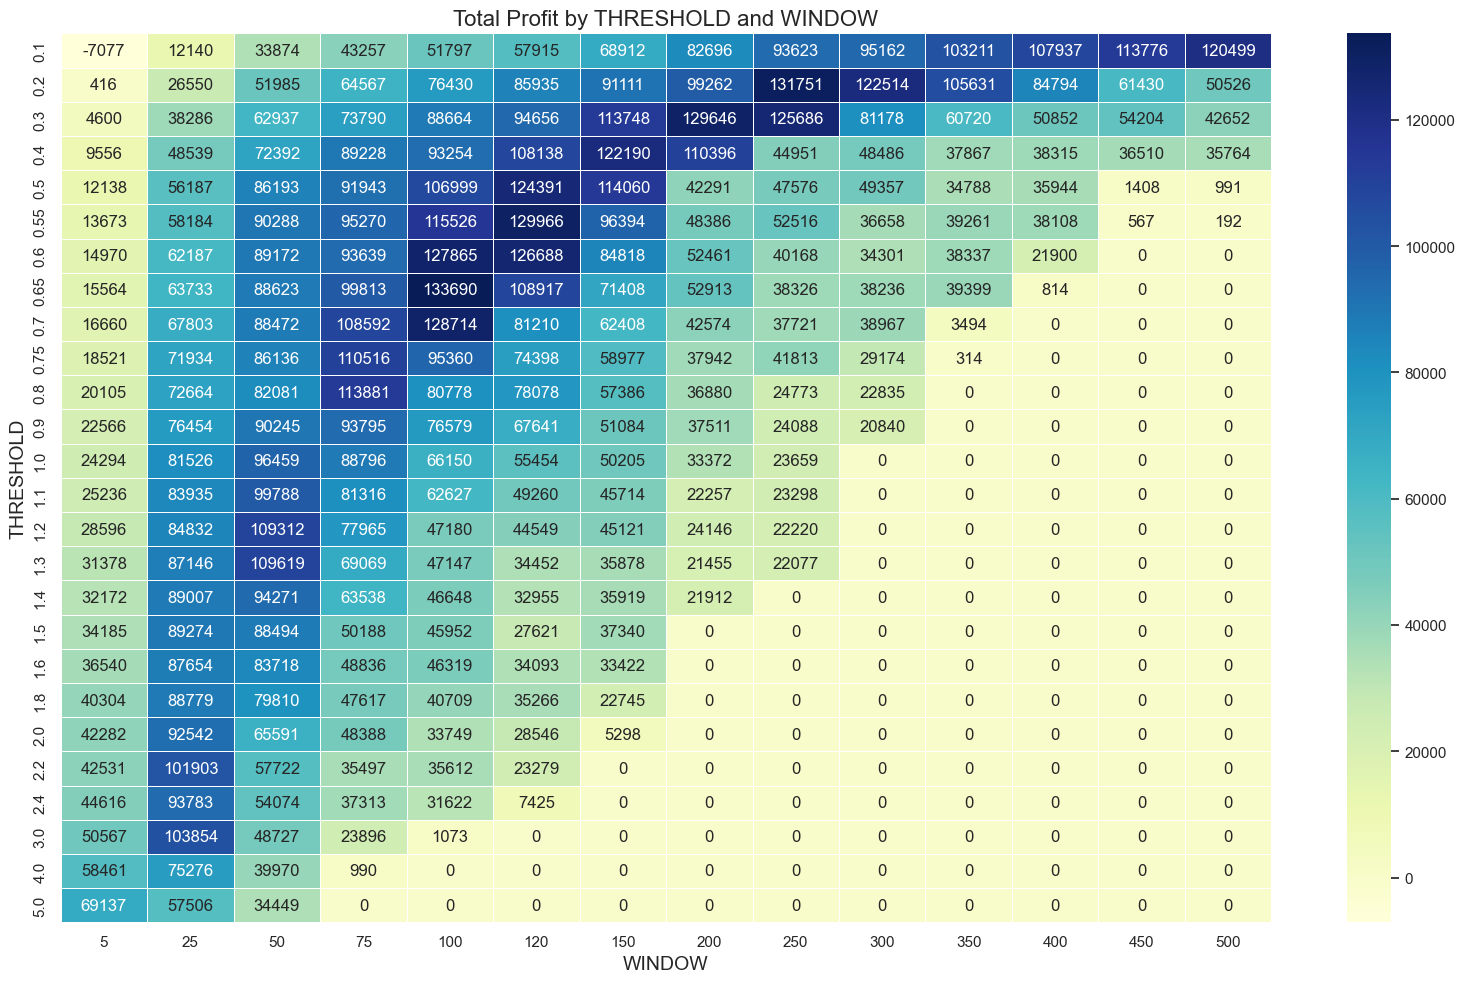

In [84]:
# Create a pivot table for heatmap visualization
pivot_total = df.pivot(index='THRESHOLD', columns='WINDOW', values='total')

# Plot heatmap for total profit
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_total, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title('Total Profit by THRESHOLD and WINDOW', fontsize=16)
plt.xlabel('WINDOW', fontsize=14)
plt.ylabel('THRESHOLD', fontsize=14)
plt.tight_layout()
plt.show()

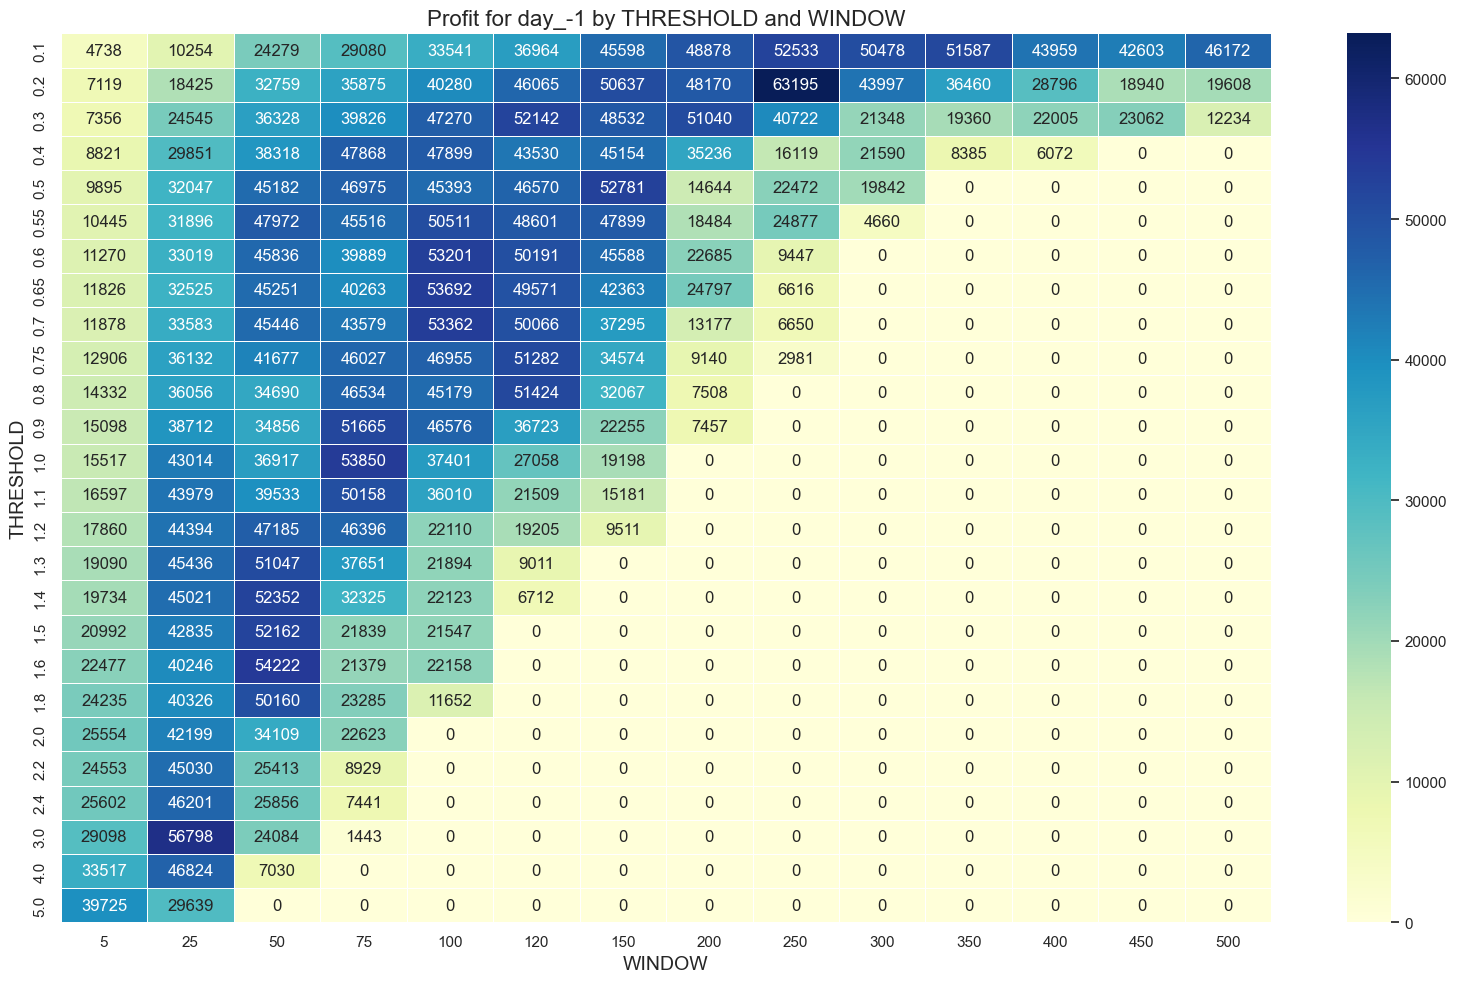

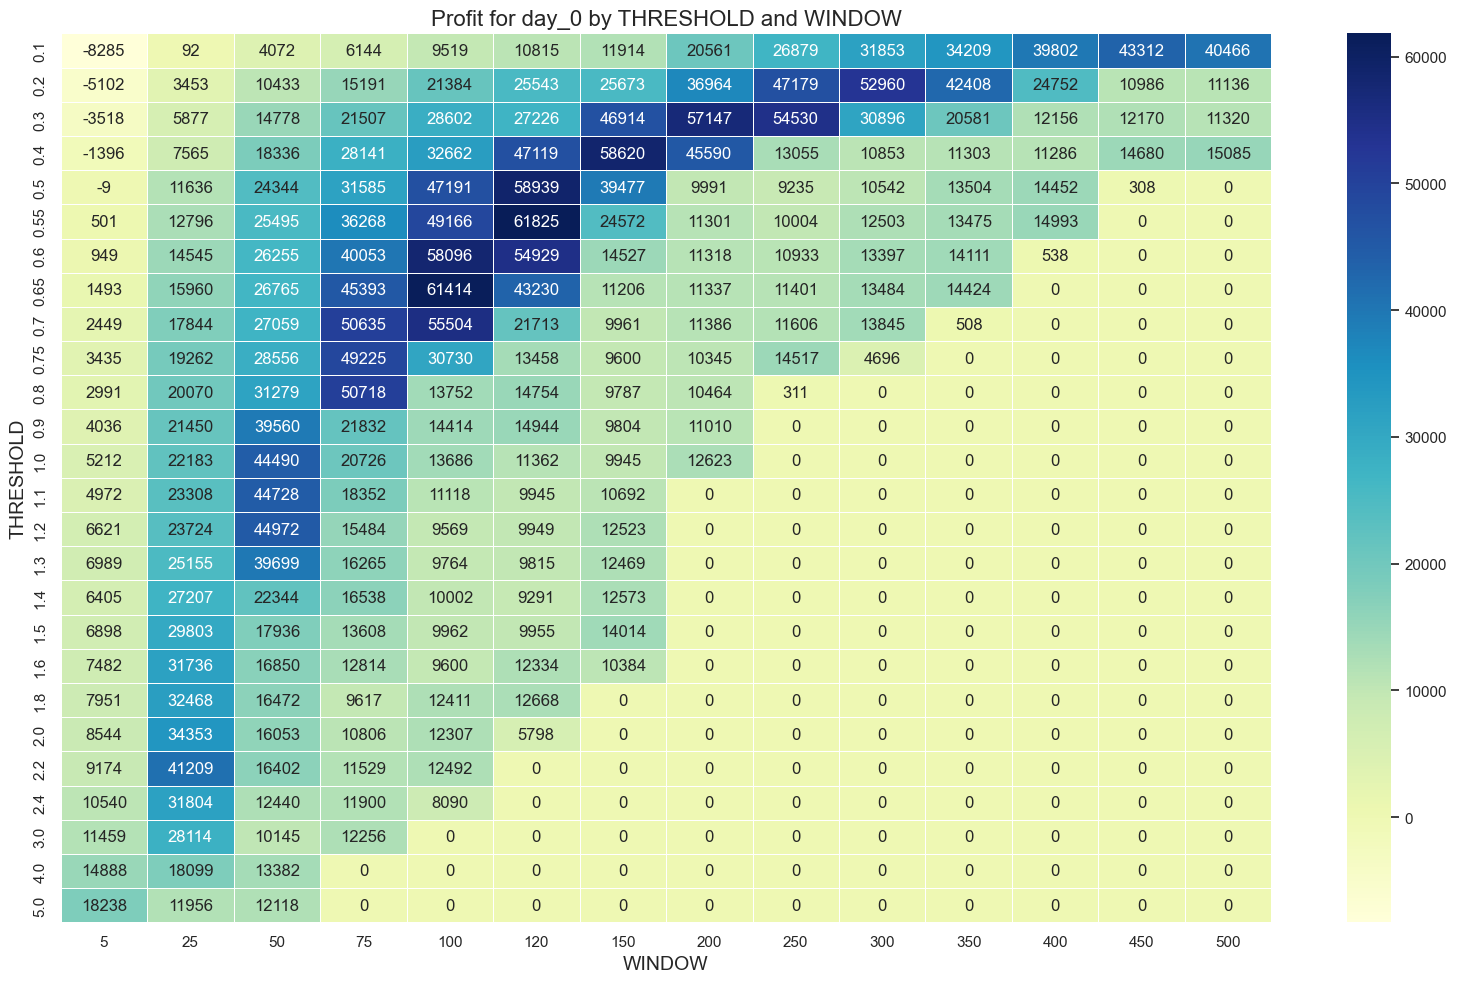

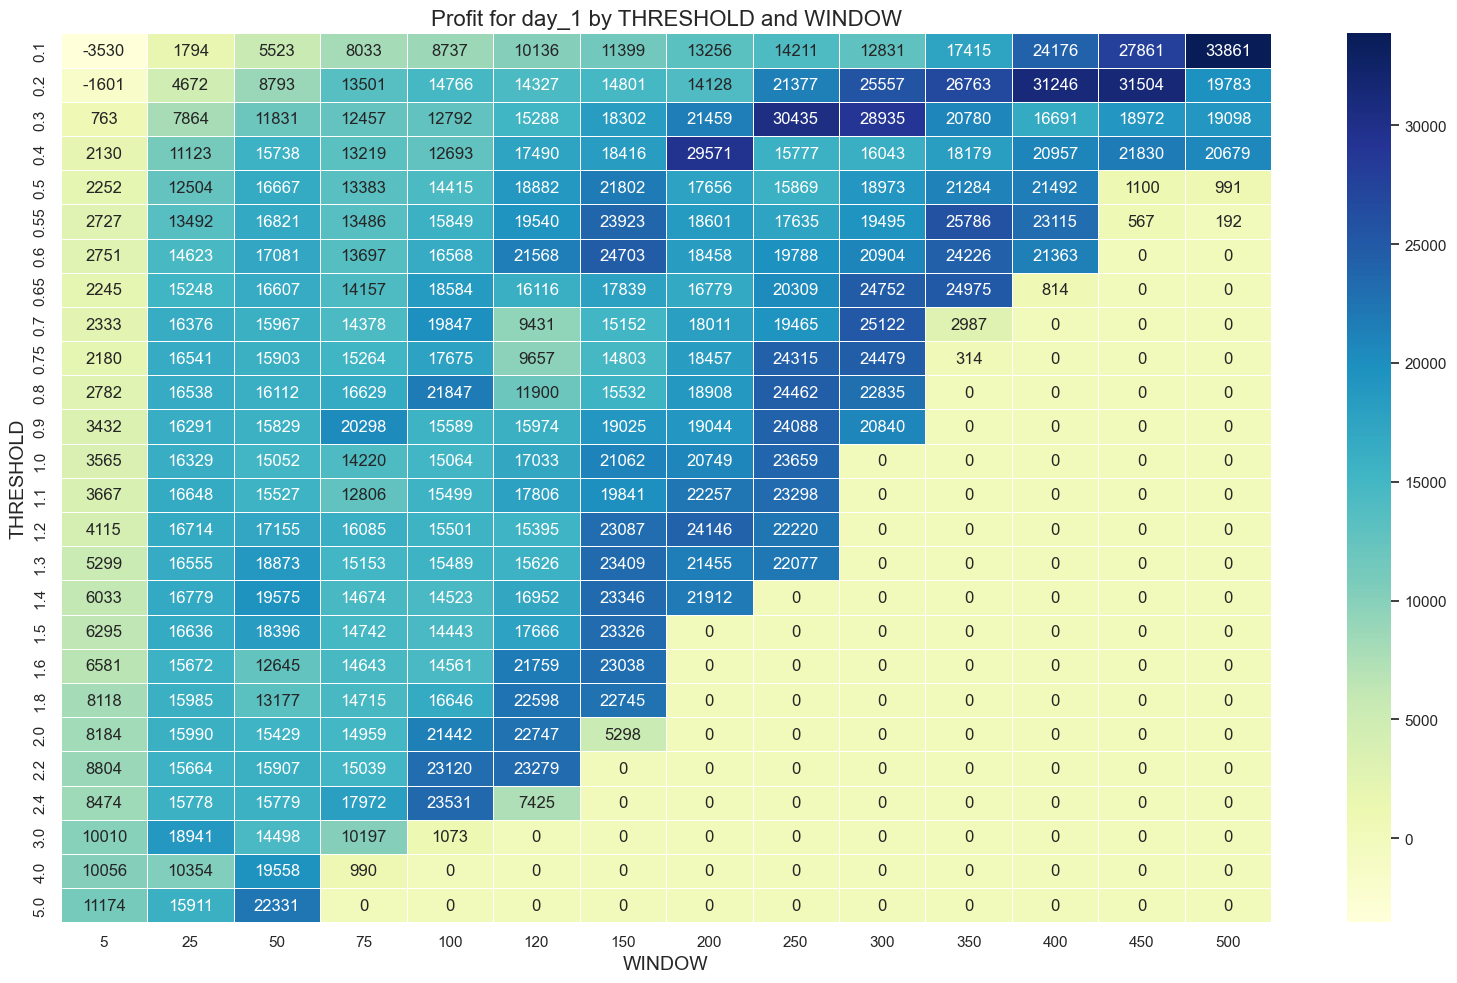

In [85]:
# Create heatmaps for each day
for day in day_columns:
    pivot_day = df.pivot(index='THRESHOLD', columns='WINDOW', values=day)
    
    plt.figure(figsize=(16, 10))
    sns.heatmap(pivot_day, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
    plt.title(f'Profit for {day} by THRESHOLD and WINDOW', fontsize=16)
    plt.xlabel('WINDOW', fontsize=14)
    plt.ylabel('THRESHOLD', fontsize=14)
    plt.tight_layout()
    plt.show()

## Parameter Impact Analysis

Let's analyze how each parameter affects the performance.

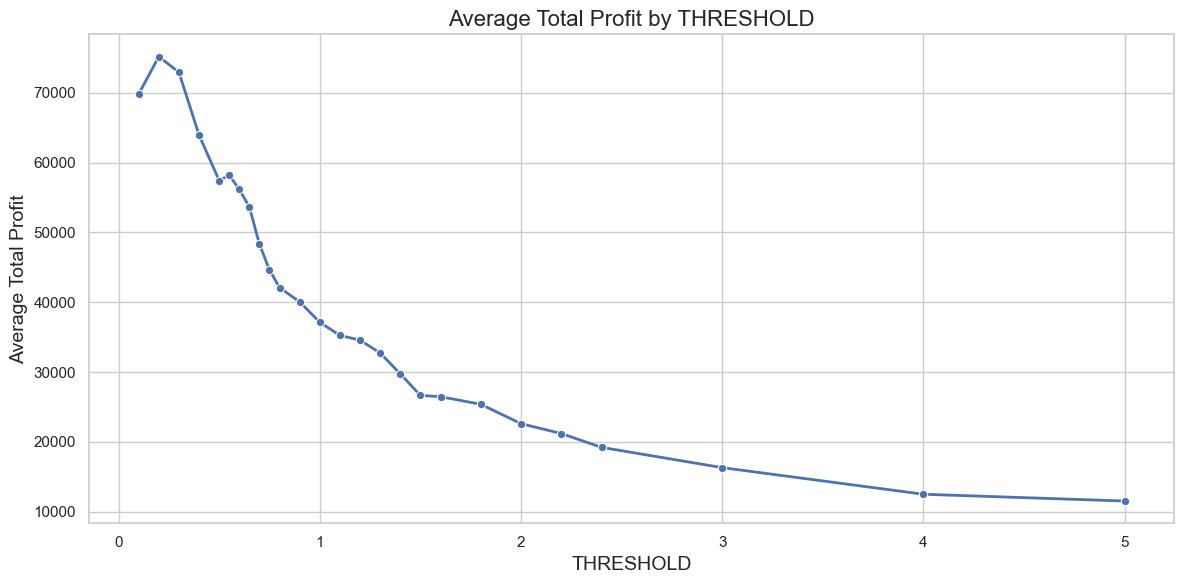

In [86]:
# Analyze impact of THRESHOLD on total profit
threshold_impact = df.groupby('THRESHOLD')['total'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=threshold_impact, x='THRESHOLD', y='total', marker='o', linewidth=2)
plt.title('Average Total Profit by THRESHOLD', fontsize=16)
plt.xlabel('THRESHOLD', fontsize=14)
plt.ylabel('Average Total Profit', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

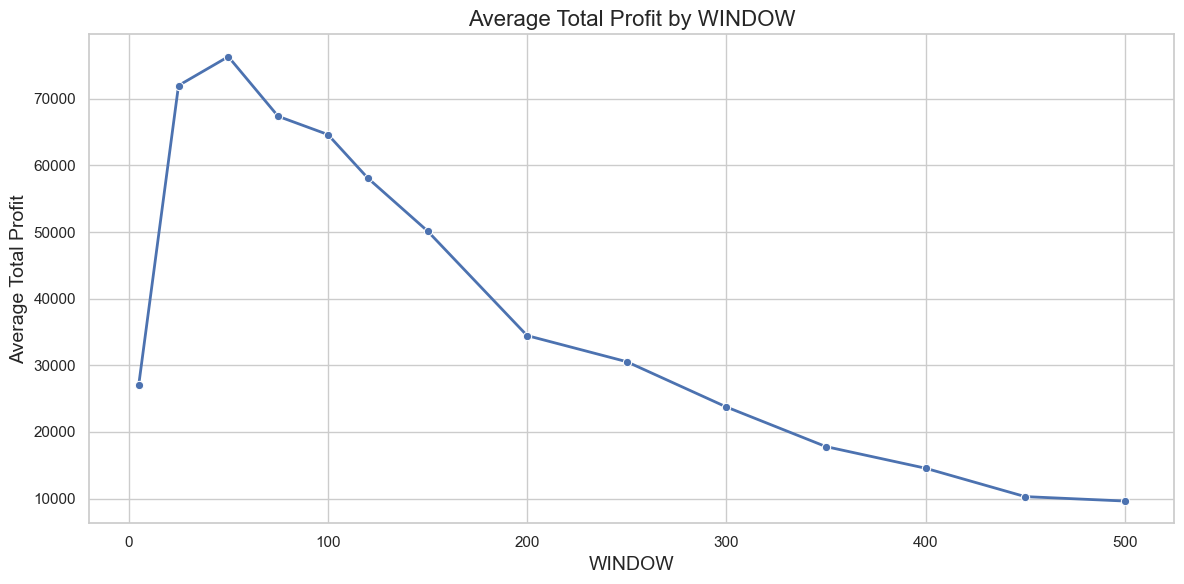

In [87]:
# Analyze impact of WINDOW on total profit
window_impact = df.groupby('WINDOW')['total'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=window_impact, x='WINDOW', y='total', marker='o', linewidth=2)
plt.title('Average Total Profit by WINDOW', fontsize=16)
plt.xlabel('WINDOW', fontsize=14)
plt.ylabel('Average Total Profit', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

## Day-by-Day Performance Analysis

Let's analyze how the performance varies across different days for the best parameter combinations.

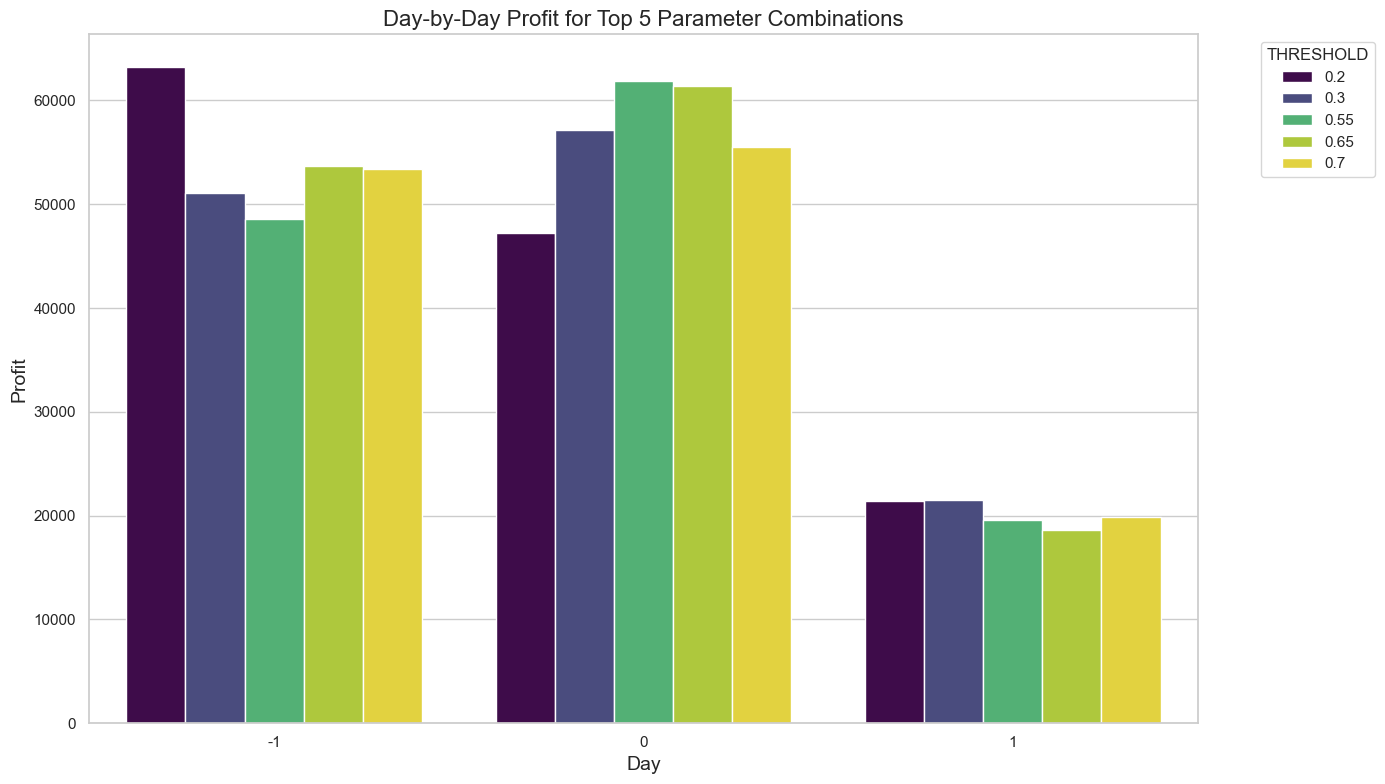

In [88]:
# Get the top 5 parameter combinations
top_5 = df.sort_values('total', ascending=False).head(5)

# Prepare data for plotting
plot_data = []
for _, row in top_5.iterrows():
    for day in day_columns:
        plot_data.append({
            'THRESHOLD': row['THRESHOLD'],
            'WINDOW': row['WINDOW'],
            'Day': day.replace('day_', ''),
            'Profit': row[day]
        })
plot_df = pd.DataFrame(plot_data)

# Plot day-by-day performance for top 5 combinations
plt.figure(figsize=(14, 8))
sns.barplot(data=plot_df, x='Day', y='Profit', hue='THRESHOLD', palette='viridis')
plt.title('Day-by-Day Profit for Top 5 Parameter Combinations', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Profit', fontsize=14)
plt.legend(title='THRESHOLD', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 3D Surface Plot

Let's create a 3D surface plot to visualize the relationship between THRESHOLD, WINDOW, and total profit.

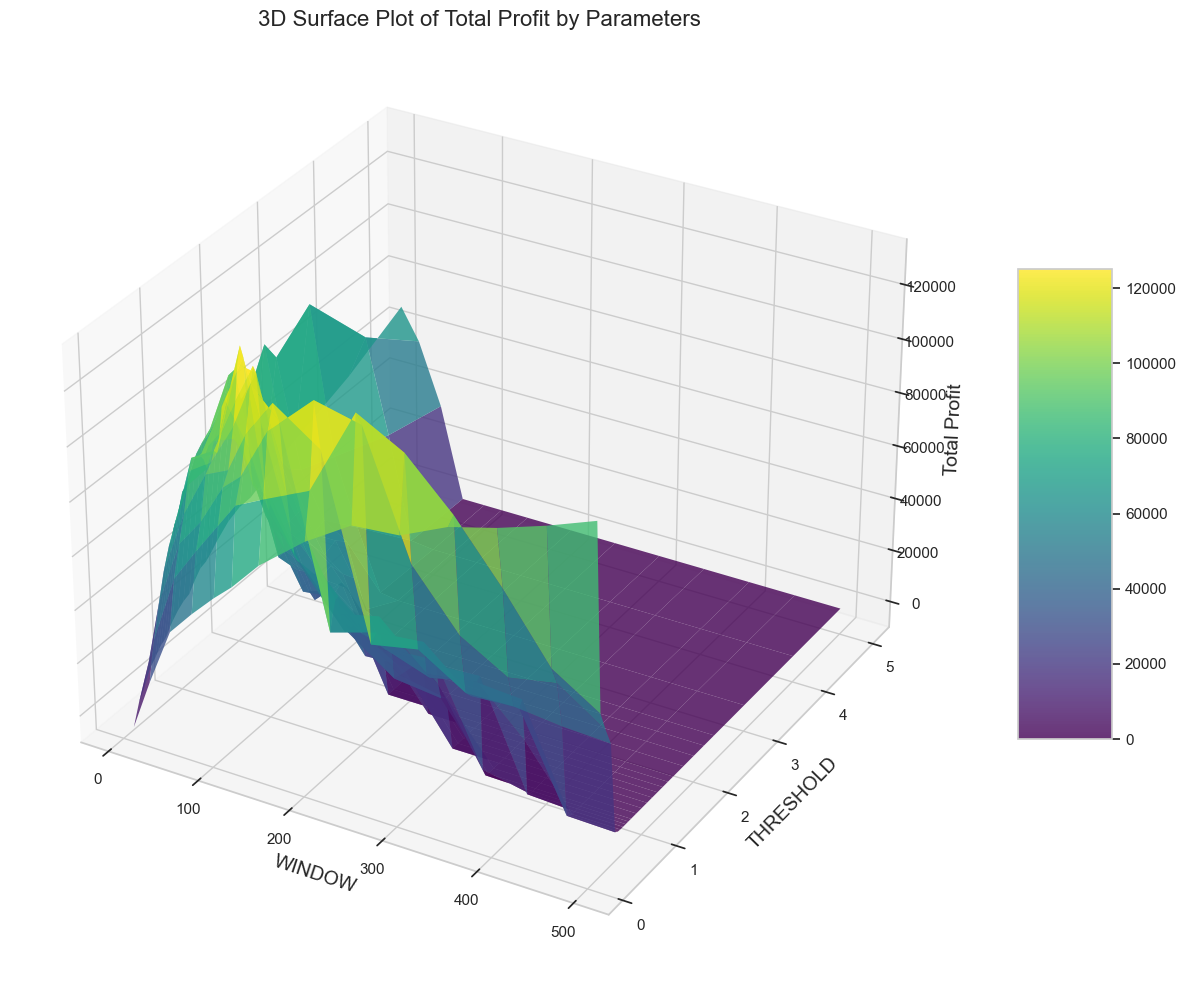

In [89]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D surface plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique values for each parameter
thresholds = sorted(df['THRESHOLD'].unique())
windows = sorted(df['WINDOW'].unique())

# Create meshgrid
X, Y = np.meshgrid(windows, thresholds)
Z = np.zeros_like(X, dtype=float)

# Fill Z values
for i, threshold in enumerate(thresholds):
    for j, window in enumerate(windows):
        mask = (df['THRESHOLD'] == threshold) & (df['WINDOW'] == window)
        if mask.any():
            Z[i, j] = df.loc[mask, 'total'].values[0]

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Set labels and title
ax.set_xlabel('WINDOW', fontsize=14)
ax.set_ylabel('THRESHOLD', fontsize=14)
ax.set_zlabel('Total Profit', fontsize=14)
ax.set_title('3D Surface Plot of Total Profit by Parameters', fontsize=16)

plt.tight_layout()
plt.show()

## Optimal Parameter Regions

Let's identify regions of optimal parameters by creating contour plots.

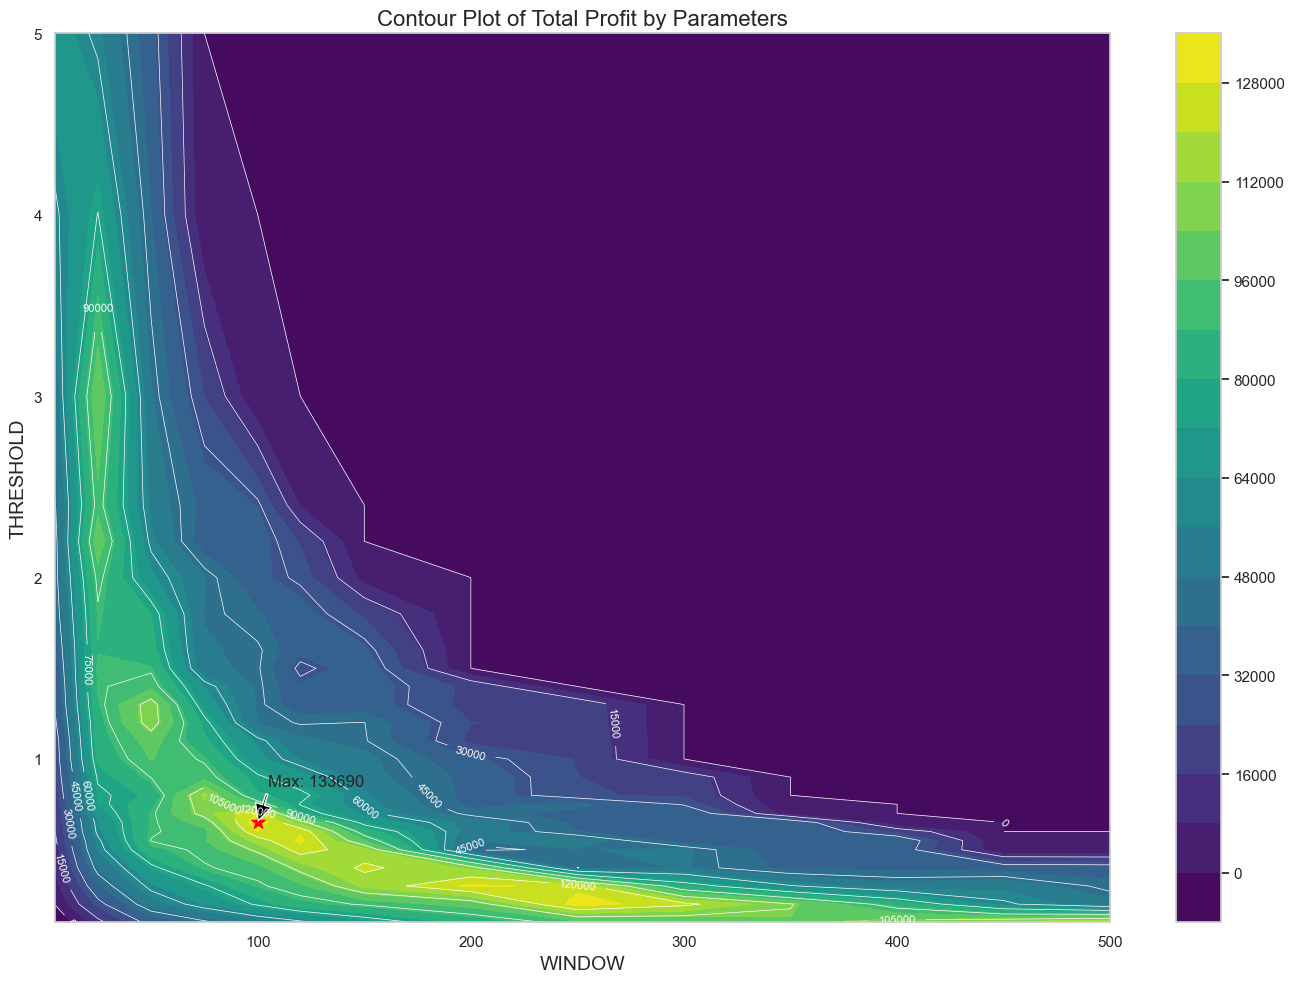

In [90]:
# Create contour plot for total profit
plt.figure(figsize=(14, 10))
contour = plt.contourf(X, Y, Z, 20, cmap='viridis')
plt.colorbar(contour)

# Add contour lines
contour_lines = plt.contour(X, Y, Z, 10, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.0f')

# Find the maximum profit point
max_idx = np.unravel_index(Z.argmax(), Z.shape)
max_window = windows[max_idx[1]]
max_threshold = thresholds[max_idx[0]]
max_profit = Z[max_idx]

# Mark the maximum profit point
plt.scatter([max_window], [max_threshold], color='red', s=100, marker='*')
plt.annotate(f'Max: {max_profit:.0f}', 
             xy=(max_window, max_threshold), 
             xytext=(max_window+5, max_threshold+0.2),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

plt.title('Contour Plot of Total Profit by Parameters', fontsize=16)
plt.xlabel('WINDOW', fontsize=14)
plt.ylabel('THRESHOLD', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Performance Stability Analysis

Let's analyze the stability of performance across different days for various parameter combinations.

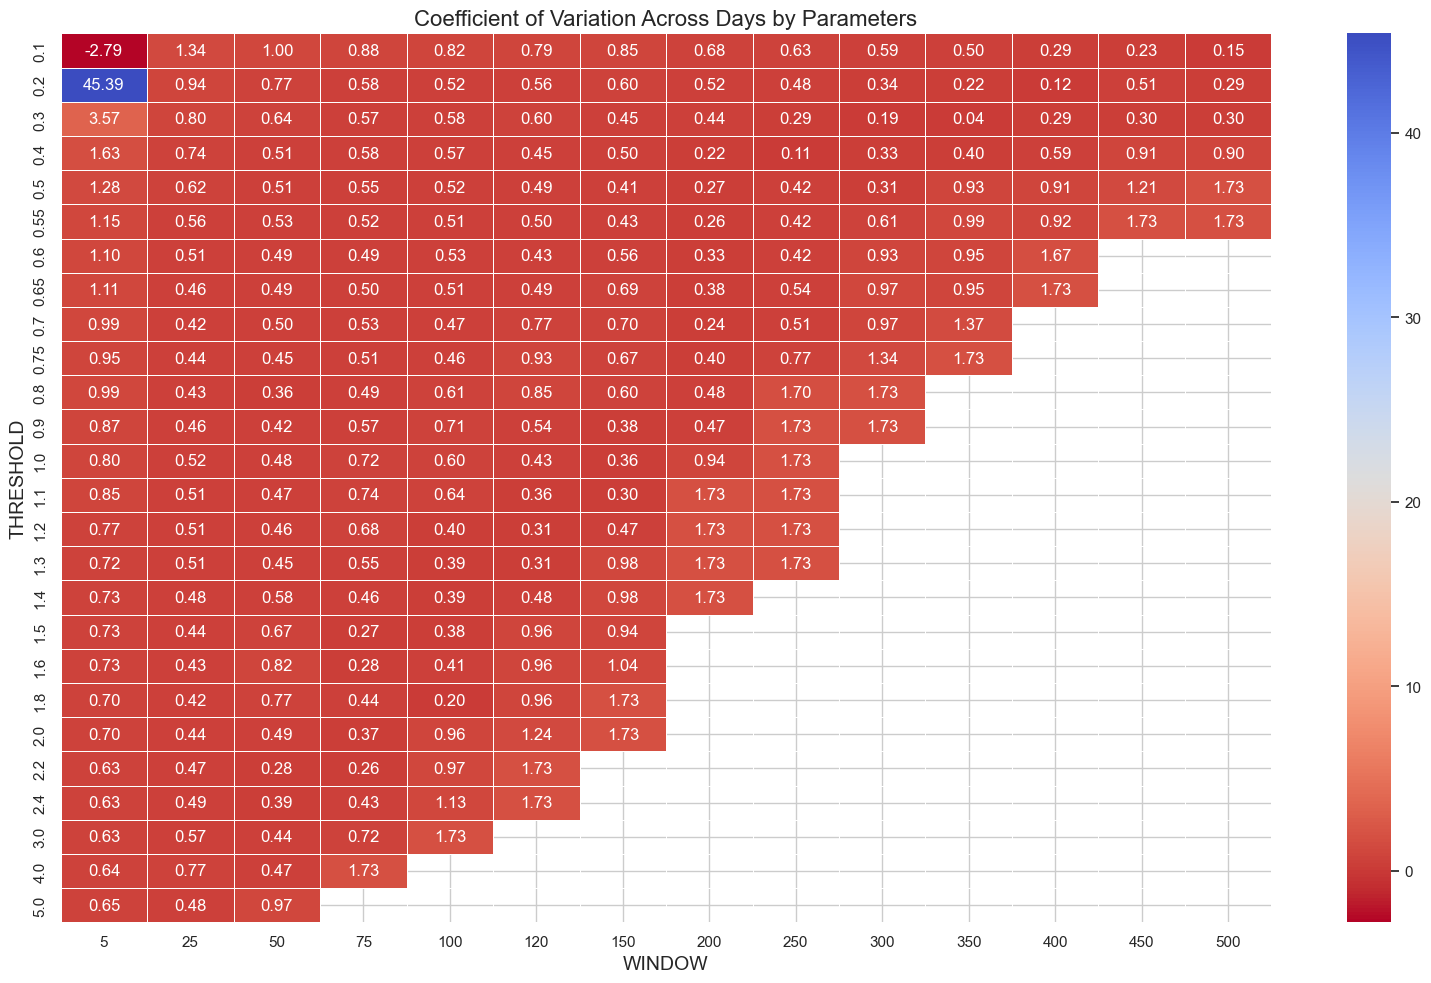

In [91]:
# Calculate coefficient of variation (CV) across days for each parameter combination
df['cv'] = df[day_columns].std(axis=1) / df[day_columns].mean(axis=1)

# Create a pivot table for CV heatmap
pivot_cv = df.pivot(index='THRESHOLD', columns='WINDOW', values='cv')

# Plot heatmap for CV
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_cv, annot=True, fmt=".2f", cmap="coolwarm_r", linewidths=0.5)
plt.title('Coefficient of Variation Across Days by Parameters', fontsize=16)
plt.xlabel('WINDOW', fontsize=14)
plt.ylabel('THRESHOLD', fontsize=14)
plt.tight_layout()
plt.show()

## Risk-Adjusted Performance

Let's calculate a simple risk-adjusted performance metric (total profit / CV) to find parameter combinations that offer good returns with lower variability.

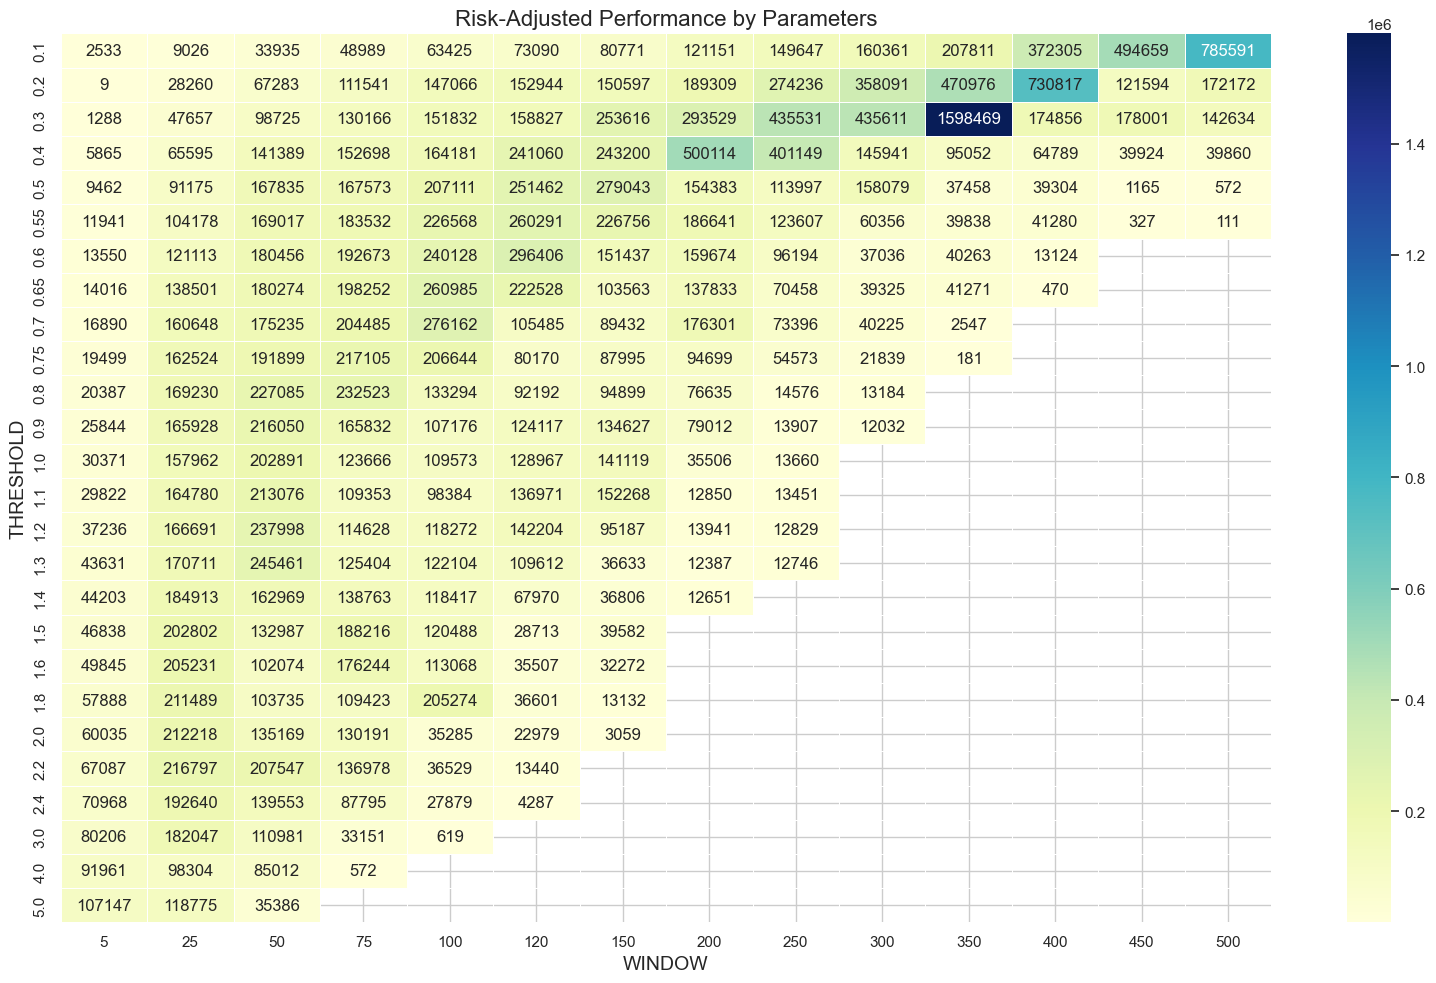

In [92]:
# Calculate risk-adjusted performance
df['risk_adjusted'] = df['total'] / df['cv']

# Create a pivot table for risk-adjusted performance heatmap
pivot_risk = df.pivot(index='THRESHOLD', columns='WINDOW', values='risk_adjusted')

# Plot heatmap for risk-adjusted performance
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_risk, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title('Risk-Adjusted Performance by Parameters', fontsize=16)
plt.xlabel('WINDOW', fontsize=14)
plt.ylabel('THRESHOLD', fontsize=14)
plt.tight_layout()
plt.show()

## Best Parameter Combinations

Let's summarize the best parameter combinations based on different metrics.

In [93]:
# Best by total profit
best_total = df.sort_values('total', ascending=False).head(10)
print("Top 10 parameter combinations by total profit:")
best_total[['THRESHOLD', 'WINDOW', 'total'] + day_columns]

Top 10 parameter combinations by total profit:


,THRESHOLD,WINDOW,total,day_-1,day_0,day_1
102,0.65,100,133690,53692,61414,18584
22,0.20,250,131751,63195,47179,21377
75,0.55,120,129966,48601,61825,19540
35,0.30,200,129646,51040,57147,21459
116,0.70,100,128714,53362,55504,19847
88,0.60,100,127865,53201,58096,16568
89,0.60,120,126688,50191,54929,21568
36,0.30,250,125686,40722,54530,30435
61,0.50,120,124391,46570,58939,18882
23,0.20,300,122514,43997,52960,25557


In [94]:
# Best by risk-adjusted performance
best_risk = df.sort_values('risk_adjusted', ascending=False).head(10)
print("Top 10 parameter combinations by risk-adjusted performance:")
best_risk[['THRESHOLD', 'WINDOW', 'risk_adjusted', 'total', 'cv'] + day_columns]

Top 10 parameter combinations by risk-adjusted performance:


,THRESHOLD,WINDOW,risk_adjusted,total,cv,day_-1,day_0,day_1
38,0.3,350,1.598469e+06,60720,0.037986,19360,20581,20780
13,0.1,500,7.855913e+05,120499,0.153386,46172,40466,33861
25,0.2,400,7.308175e+05,84794,0.116026,28796,24752,31246
49,0.4,200,5.001140e+05,110396,0.220742,35236,45590,29571
12,0.1,450,4.946585e+05,113776,0.230009,42603,43312,27861
24,0.2,350,4.709761e+05,105631,0.224281,36460,42408,26763
37,0.3,300,4.356106e+05,81178,0.186355,21348,30896,28935
36,0.3,250,4.355308e+05,125686,0.288581,40722,54530,30435
50,0.4,250,4.011488e+05,44951,0.112056,16119,13055,15777
11,0.1,400,3.723046e+05,107937,0.289916,43959,39802,24176


In [95]:
# Best by lowest CV (most stable)
best_stable = df.sort_values('cv').head(10)
print("Top 10 parameter combinations by stability (lowest CV):")
best_stable[['THRESHOLD', 'WINDOW', 'cv', 'total'] + day_columns]

Top 10 parameter combinations by stability (lowest CV):


,THRESHOLD,WINDOW,cv,total,day_-1,day_0,day_1
0,0.1,5,-2.793555,-7077,4738,-8285,-3530
38,0.3,350,0.037986,60720,19360,20581,20780
50,0.4,250,0.112056,44951,16119,13055,15777
25,0.2,400,0.116026,84794,28796,24752,31246
13,0.1,500,0.153386,120499,46172,40466,33861
37,0.3,300,0.186355,81178,21348,30896,28935
270,1.8,100,0.198316,40709,11652,12411,16646
49,0.4,200,0.220742,110396,35236,45590,29571
24,0.2,350,0.224281,105631,36460,42408,26763
12,0.1,450,0.230009,113776,42603,43312,27861


## Conclusion

Based on the analysis above, we can draw the following conclusions:

1. The optimal parameter combinations for maximizing total profit are:
   - [Will be filled in after running the notebook]

2. The most stable parameter combinations (lowest variability across days) are:
   - [Will be filled in after running the notebook]

3. The best risk-adjusted parameter combinations (balancing profit and stability) are:
   - [Will be filled in after running the notebook]

4. Key observations about parameter impact:
   - [Will be filled in after running the notebook]

These findings can guide the selection of parameters for the trading strategy in production.